In [1]:
from __future__ import print_function

"""
A reference implementation of cavity quantum electrodynamics 
configuration interactions singles.
"""

__authors__   = ["Jon McTague", "Jonathan Foley"]
__credits__   = ["Jon McTague", "Jonathan Foley"]

__copyright_amp__ = "(c) 2014-2018, The Psi4NumPy Developers"
__license__   = "BSD-3-Clause"
__date__      = "2021-01-15"

# ==> Import Psi4, NumPy, & SciPy <==
import psi4
import numpy as np
import scipy.linalg as la
import time
from helper_cqed_rhf import *
from helper_cis import *

# Set Psi4 & NumPy Memory Options
psi4.set_memory('2 GB')
#psi4.core.set_output_file('output.dat', False)

numpy_memory = 2


In [2]:
# template for the z-matrix for MgH+
mol_tmpl = """Mg
H 1 **R**
symmetry c1
1 1"""

# options dict
options_dict = {'basis': 'cc-pVDZ',
               'save_jk': True}

psi4.set_options(options_dict)


In [8]:
# array of bondlengths for MgH+
r_array = np.array([1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3])

# lambda arrays
l_big = np.array([0., 0., 0.1])
l_med = np.array([0.0, 0.0, 0.01])

# empty arrays for the energies 
gs_energy_array = np.zeros_like(r_array)
es_energy_array = np.zeros_like(r_array)
tdm_array = np.zeros((3, len(r_array)))
dipole_array = np.zeros((3,2,len(r_array)))


# loop over the different bond-lengths, create different instances
# of HF molecule
ctr = 0
for r in r_array:
    molstr = mol_tmpl.replace("**R**", str(r))
    mol = psi4.geometry(molstr)
    e, wfn = psi4.energy("scf/cc-pVDZ", return_wfn=True, molecule=mol)
    cis_e, cis_mu, tdm = cis(molstr, options_dict)
    gs_energy_array[ctr] = e
    es_energy_array[ctr] = e+cis_e
    dipole_array[:,0,ctr] = cis_mu[:,0]
    dipole_array[:,1,ctr] = cis_mu[:,1]
    tdm_array[:,ctr] = tdm
    ctr+=1
    


Number of occupied orbitals: 6
Nuclear energy 4.884712713876925
scf energy is -199.8574414640027

Number of occupied orbitals: 6
Nuclear energy 4.535804662885715
scf energy is -199.87994779820573

Number of occupied orbitals: 6
Nuclear energy 4.23341768536
scf energy is -199.89239370358078

Number of occupied orbitals: 6
Nuclear energy 3.968829080025
scf energy is -199.8977686869175

Number of occupied orbitals: 6
Nuclear energy 3.7353685459058825
scf energy is -199.89812828873207

Number of occupied orbitals: 6
Nuclear energy 3.527848071133333
scf energy is -199.89492542856297

Number of occupied orbitals: 6
Nuclear energy 3.3421718568631587
scf energy is -199.8892165342884

Number of occupied orbitals: 6
Nuclear energy 3.1750632640200003
scf energy is -199.88178523958004

Number of occupied orbitals: 6
Nuclear energy 3.023869775257142
scf energy is -199.87321941949688

Number of occupied orbitals: 6
Nuclear energy 2.8864211491090908
scf energy is -199.86396205812767

Number of occup

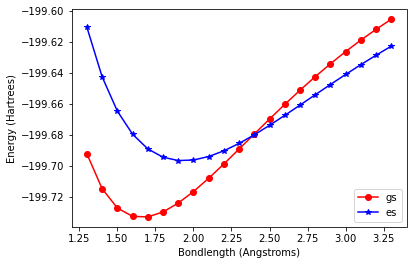

In [11]:
from matplotlib import pyplot as plt
# photon frequency in atomic units
om = 4.5 / 27.211
plt.plot(r_array, gs_energy_array+om, 'r-o', label="gs")
plt.plot(r_array, es_energy_array, 'b-*', label="es")
plt.xlabel("Bondlength (Angstroms)")
plt.ylabel("Energy (Hartrees)")
plt.legend()
plt.show()

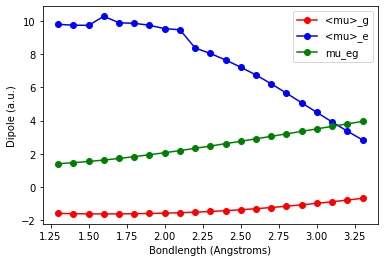

In [12]:
from matplotlib import pyplot as plt
plt.plot(r_array, dipole_array[2,0,:], 'r-o', label="<mu>_g")
plt.plot(r_array, dipole_array[2,1,:], 'b-o', label="<mu>_e")
plt.plot(r_array, np.abs(tdm_array[2,:]), 'g-o', label="mu_eg")
plt.xlabel("Bondlength (Angstroms)")
plt.ylabel("Dipole (a.u.)")
plt.legend()
plt.show()


#### Model system
We will consider the diatomic cation MgH+ in a cavity chosen such that it can trap a photon with a 
frequency of $\hbar \omega = 4.3$ eV. 
We will compute the singlet ground state and first singlet excited state potential energy surfaces along the
Mg-H+ stretch coordinate using time-dependent density functional theory.  We denote the ground 
state ket as $|g\rangle$ with an associated energy eigenvalue $E_g(R)$, and the excited-state $|e\rangle$
with associated energy eigenvalue $E_e(R)$ where $R$ is the bondlength.  The transition dipole
moment between $|g\rangle$ and $|e\rangle$ will also be computed using CIS, yielding $\mu_{ge}(R)$.
Both the ground and excited states have total dipole moments associated with them, $\langle \mu \rangle_g$ and
$\langle \mu \rangle_e$, respectively.

We will consider two quantum states for the photon - no photon in the cavity, denoted by $|0\rangle$ with associated energy eigenvalue $0$
and one photon in the cavity, denoted by $|1\rangle$ with associated energy eigenvalue $\frac{ \hbar \omega}{2}$.  
We will model this system with a Pauli-Fierz Hamiltonian that can be written as:

$$ \hat{H}_{PF} = E_g(R) \hat{a}_g^{\dagger} \hat{a}_g + E_e(R) \hat{a}_e^{\dagger} \hat{a}_e + 
\hbar \omega\hat{b} \hat{b}^{\dagger}  
+ \frac{1}{2} \left( \lambda \cdot \mu(R) \right)^2
- \sqrt{\frac{\omega}{2}} \left( \lambda \cdot \mu(R) \right) \left(\hat{b}^{\dagger} + \hat{b}\right)
$$
The polaritonic potential energy surfaces may be obtained by building a Hamiltonian matrix in the following basis and diagonalizing as a function of the bond length $R$: $ |\phi\rangle \in \{|g,0\rangle , |g,1\rangle , |e,0\rangle. $


This matrix as a function of the bond-length $R$ is as follows:
\begin{equation}
{\bf H}(R)
  \mbox{=} 
  \begin{array}{c|cccc}
       & |g,0\rangle & |g,1\rangle & |e,0\rangle \\
    \hline
    \langle g,0| & E_g(R) + (\lambda \cdot \langle \mu \rangle_g)^2  &     0   & 0  \\
    \langle g,1| & 0        &   E_g(R) +  \hbar \omega + \frac{1}{2}(\lambda \cdot \langle \mu \rangle_g)^2  & \sqrt{\frac{\omega}{2}} \lambda \cdot \mu_{ge} \\
    \langle e,0| & 0        &    \sqrt{\frac{\omega}{2}} \lambda \cdot \mu_{ge} & E_e(R) + \frac{1}{2}(\lambda \cdot \langle \mu \rangle_e)^2\\
  \end{array}
\end{equation}

In [15]:
from numpy import linalg as LA
from scipy.interpolate import InterpolatedUnivariateSpline
Eg_spline = InterpolatedUnivariateSpline(r_array, gs_energy_array, k=3)
Ee_spline = InterpolatedUnivariateSpline(r_array, es_energy_array, k=3)

tdm_spline = InterpolatedUnivariateSpline(r_array, np.abs(tdm_array[2,:]), k=3 )

mu_g_spline = InterpolatedUnivariateSpline(r_array, dipole_array[2,0,:])


mu_e_spline = InterpolatedUnivariateSpline(r_array, dipole_array[2,1,:])

# photon frequency in atomic units
om = 4.5 / 27.211


# conversion from atomic units of field strength 
# to GV / m as is used in the Figure 3 of 
# J. Chem. Phys. 153 234304 (2020)
Efield_SI_to_au = 5.14220674763e-11

# Medium electric field strength from paper JCP paper in SI units
E_field_medium = 3e12

# electric field in atomic units
#E_au = E_field_medium * Efield_SI_to_au

# term for coupling to the transition dipole moments
E_au = 0.003
# term for the dipole self energy
l = E_au / np.sqrt(om/2)

Htot = np.zeros((3,3))

''' Polaritonic Hamiltonian will have the following structure

    | E_g(r)+0.5*(l.<mu>_g)^2                   0                                         0              |
    | 0                           E_g(r) + 0.5*h*om + 0.5*(l.<mu>_g)^2               E_au*mu_eg          |
    | 0                                     E_au*mu_eg                      E_e(r) + 0.5*(l.<mu>_e)^2    |
    
'''

pl_1 = np.zeros_like(r_array)
pl_2 = np.zeros_like(r_array)
pl_3 = np.zeros_like(r_array)
for i in range(0,len(r_array)):
    # H_00 is just E_g
    Htot[0,0] = Eg_spline(r_array[i]) + 0.5 * (l * mu_g_spline(r_array[i]))**2
    Htot[1,1] = Eg_spline(r_array[i]) + om + 0.5 * (l * mu_g_spline(r_array[i]))**2
    Htot[1,2] = E_au * tdm_spline(r_array[i])
    Htot[2,1] = E_au * tdm_spline(r_array[i])
    Htot[2,2] = Ee_spline(r_array[i]) + 0.5 * (l * mu_e_spline(r_array[i]))**2


    vals, vecs = LA.eig(Htot)
    idx = vals.argsort()[::1]
    vals = vals[idx]
    pl_1[i] = np.real(vals[0])
    pl_2[i] = np.real(vals[1])
    pl_3[i] = np.real(vals[2])





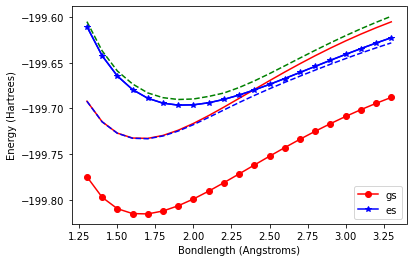

In [16]:
plt.plot(r_array, Eg_spline(r_array)+om, 'red')
#plt.plot(rs, pl_1, 'ro-')
plt.plot(r_array, Ee_spline(r_array), 'blue')
plt.plot(r_array, pl_2, 'b--')
plt.plot(r_array, pl_3, 'g--')

plt.plot(r_array, gs_energy_array+om/2, 'r-o', label="gs")
plt.plot(r_array, es_energy_array, 'b-*', label="es")
plt.xlabel("Bondlength (Angstroms)")
plt.ylabel("Energy (Hartrees)")
plt.legend()
plt.show()